In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model,regularizers,datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from packaging import version
from  IPython import display
from keras.callbacks import ModelCheckpoint
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.3.0


# Mount the drive and specify the path to the weights:

**Important note!**
Before running this notebook in your Google Drive:
- Locate the shared folder.
- Right click and choose "Add a shortcut to Drive".
- This way Colab will be able to access the shared drive from a mounted destination.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
ex_folder = "/content/drive/My Drive/ex1_304867716_321297111/Models/"

# Get The Data, Prepare and Split

In [15]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [16]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
(28, 28) image shape


In [17]:
# Add a new axis
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
(28, 28, 1) image shape


In [18]:
# Convert class vectors to binary class matrices.
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [19]:
# Data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Model Architecture:

In [20]:
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes,Drop=None,BNorm=None,regularizer=None):
    super().__init__()
    self.Drop = Drop
    self.BNorm = BNorm
    self.regularizer = regularizer
    if regularizer=="Weight_Decay":
      ker_reg="l2"
    else:
      ker_reg=None
      drop_val=0.2
    # 1st Conv Layer 
    self.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu',
                    input_shape=input_shape, padding="same",
                    kernel_regularizer=ker_reg))
    self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    if Drop=="Dropout":
      self.add(tf.keras.layers.Dropout(drop_val))
    if BNorm=="BatchNormalization":
      self.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    # 2nd Conv Layer
    self.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu',
                    padding='same',kernel_regularizer=ker_reg))
    self.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    if Drop=="Dropout":
      self.add(tf.keras.layers.Dropout(drop_val))
    if BNorm=="BatchNormalization":
      self.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    # 3rd Fully Connected Layer 
    self.add(Flatten())
    self.add(Dense(120, activation='relu'))
    if Drop=="Dropout":
      self.add(tf.keras.layers.Dropout(drop_val))
    if BNorm=="BatchNormalization":
      self.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    #5th Fully Connected Layer
    self.add(Dense(84, activation='relu'))
    if Drop=="Dropout":
      self.add(tf.keras.layers.Dropout(drop_val))
    if BNorm=="BatchNormalization":
      self.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    # Output Layer
    self.add(Dense(nb_classes, activation='softmax'))
    
def compile_model(model):
  eval(model).compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [21]:
model_clean = LeNet(x_train[0].shape, num_classes)
model_Dropout=LeNet(x_train[0].shape, num_classes,"Dropout")
model_BNorm=LeNet(x_train[0].shape, num_classes, None, "BatchNormalization")
model_Weight_Decay=LeNet(x_train[0].shape, num_classes, None, None, "Weight_Decay")

# Train and Validate Models:

In [22]:
models=["model_clean", "model_Dropout", "model_BNorm", "model_Weight_Decay"]

total_scores_test=[]
total_scores_train=[]
total_model_fit=[]

for model in models:
  print(model)
  print("-------------")

  file_path = ex_folder + model + '.weights.best.hdf5'
  model_fit = eval(model)
  model_fit.load_weights(file_path)
  model_fit.summary()
  compile_model(model)

  #Accuracy on testing data
  score_train = model_fit.evaluate(x_train, y_train, verbose=0)
  score_test = model_fit.evaluate(x_test, y_test, verbose=0)
  total_scores_test.append(score_test)
  total_scores_train.append(score_train)
  total_model_fit.append(model_fit)

model_clean
-------------
Model: "le_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_8 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
average_pooling2d_9 (Average (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_13 (Dense)             (No

In [23]:
total_scores_test_loss=list(map(list, zip(*total_scores_test)))[0]
total_scores_test_acc=list(map(list, zip(*total_scores_test)))[1]
total_scores_train_loss=list(map(list, zip(*total_scores_train)))[0]
total_scores_train_acc=list(map(list, zip(*total_scores_train)))[1]

df = pd.DataFrame(list(zip(total_scores_train_acc,total_scores_test_acc,
                           total_scores_train_loss,total_scores_test_loss)),
                  columns=['accuracy train','accuracy test','loss train','loss test'],
                  index=models)
df.round(3)       

,accuracy train,accuracy test,loss train,loss test
model_clean,0.933,0.906,0.180,0.257
model_Dropout,0.945,0.920,0.151,0.226
model_BNorm,0.953,0.916,0.126,0.242
model_Weight_Decay,0.932,0.898,0.207,0.310


In [24]:
display.IFrame(src="https://tensorboard.dev/experiment/j0TVoKxRSPC1MNVyVOPEbw/#scalars&_smoothingWeight=0",
    width = "100%", height="800px")

best model is:  model_Dropout
-------------------------------
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


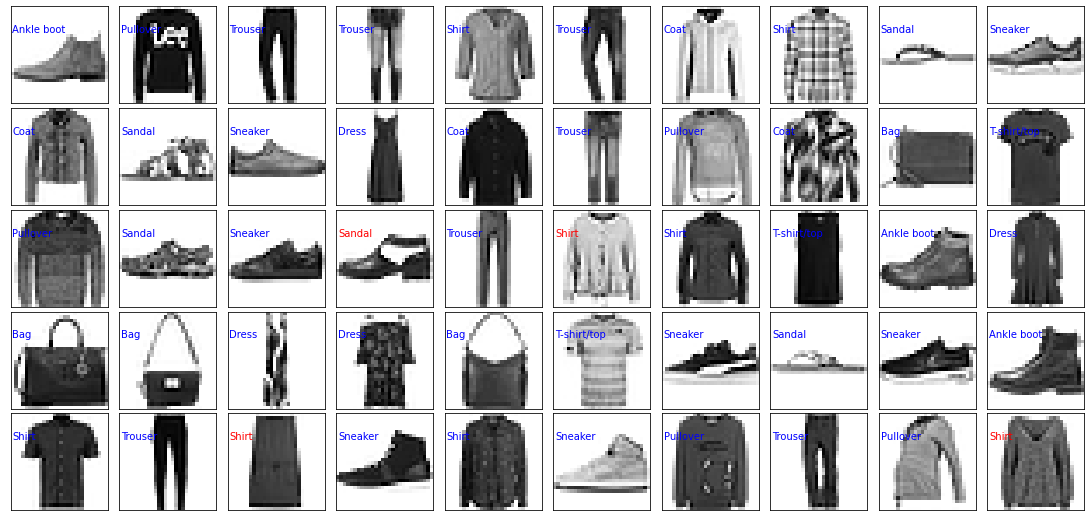

In [25]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
best_model = df["accuracy test"].idxmax() 
print("best model is: ", best_model)
print("-------------------------------")
prediction_values = eval(best_model).predict_classes(x_test)

# set up the figure
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 28x28 pixels
for i in range(50):
  ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
  ax.imshow(x_test[i,:].reshape((28,28)),cmap=plt.cm.gray_r, interpolation='nearest')
  
  if prediction_values[i] == np.argmax(y_test[i]):
    # label the image with the blue text
    ax.text(0, 7, class_names[prediction_values[i]], color='blue')
  else:
    # label the image with the red text
    ax.text(0, 7, class_names[prediction_values[i]], color='red')



---

